<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/tutorials/W1D1_ModelTypes/W1D1_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W1D1_ModelTypes/W1D1_Tutorial3.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 3: "Why" models
**Week 1, Day 1: Model Types**

**By Neuromatch Academy**

__Content creators:__ Matt Laporte, Byron Galbraith, Konrad Kording

__Content reviewers:__ Dalin Guo, Aishwarya Balwani, Madineh Sarvestani, Maryam Vaziri-Pashkam, Michael Waskom, Ella Batty

__Post-production team:__ Gagana B, Spiros Chavlis

We would like to acknowledge [Steinmetz _et al._ (2019)](https://www.nature.com/articles/s41586-019-1787-x) for sharing their data, a subset of which is used here.


<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

___
# Tutorial Objectives

*Estimated timing of tutorial: 45 minutes*

This is tutorial 3 of a 3-part series on different flavors of models used to understand neural data. In parts 1 and 2 we explored mechanisms that would produce the data. In this tutorial we will explore models and techniques that can potentially explain *why* the spiking data we have observed is produced the way it is.

To understand why different spiking behaviors may be beneficial, we will learn about the concept of entropy. Specifically, we will:

- Write code to compute formula for entropy, a measure of information
- Compute the entropy of a number of toy distributions
- Compute the entropy of spiking activity from the Steinmetz dataset

In [1]:
# @title Tutorial slides

# @markdown These are the slides for the videos in all tutorials today
from IPython.display import IFrame
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/6dxwe/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

In [2]:
# @title Video 1: “Why” models
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV16t4y1Q7DR", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="OOIDEr1e5Gg", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

# Setup

In [3]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [4]:
#@title Figure Settings
import ipywidgets as widgets #interactive display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [5]:
#@title Plotting Functions

def plot_pmf(pmf,isi_range):
  """Plot the probability mass function."""
  ymax = max(0.2, 1.05 * np.max(pmf))
  pmf_ = np.insert(pmf, 0, pmf[0])
  plt.plot(bins, pmf_, drawstyle="steps")
  plt.fill_between(bins, pmf_, step="pre", alpha=0.4)
  plt.title(f"Neuron {neuron_idx}")
  plt.xlabel("Inter-spike interval (s)")
  plt.ylabel("Probability mass")
  plt.xlim(isi_range);
  plt.ylim([0, ymax])

In [6]:
#@title Download Data
import io
import requests
r = requests.get('https://osf.io/sy5xt/download')
if r.status_code != 200:
  print('Could not download data')
else:
  steinmetz_spikes = np.load(io.BytesIO(r.content), allow_pickle=True)['spike_times']

---
# Section 1: Optimization and Information

*Remember that the notation section is located after the Summary for quick reference!*

Neurons can only fire so often in a fixed period of time, as the act of emitting a spike consumes energy that is depleted and must eventually be replenished. To communicate effectively for downstream computation, the neuron would need to make good use of its limited spiking capability. This becomes an optimization problem: 

What is the optimal way for a neuron to fire in order to maximize its ability to communicate information?

In order to explore this question, we first need to have a quantifiable measure for information. Shannon introduced the concept of entropy to do just that, and defined it as

\begin{equation}
H_b(X) = -\sum_{x\in X} p(x) \log_b p(x)
\end{equation}

where $H$ is entropy measured in units of base $b$ and $p(x)$ is the probability of observing the event $x$ from the set of all possible events in $X$. See the Bonus Section 1 for a more detailed look at how this equation was derived.

The most common base of measuring entropy is $b=2$, so we often talk about *bits* of information, though other bases are used as well (e.g. when $b=e$ we call the units *nats*).

First, let's explore how entropy changes between some simple discrete probability distributions. In the rest of this tutorial we will refer to these as probability mass functions (PMF), where $p(x_i)$ equals the $i^{th}$ value in an array, and mass refers to how much of the distribution is contained at that value.

For our first PMF, we will choose one where all of the probability mass is located in the middle of the distribution.

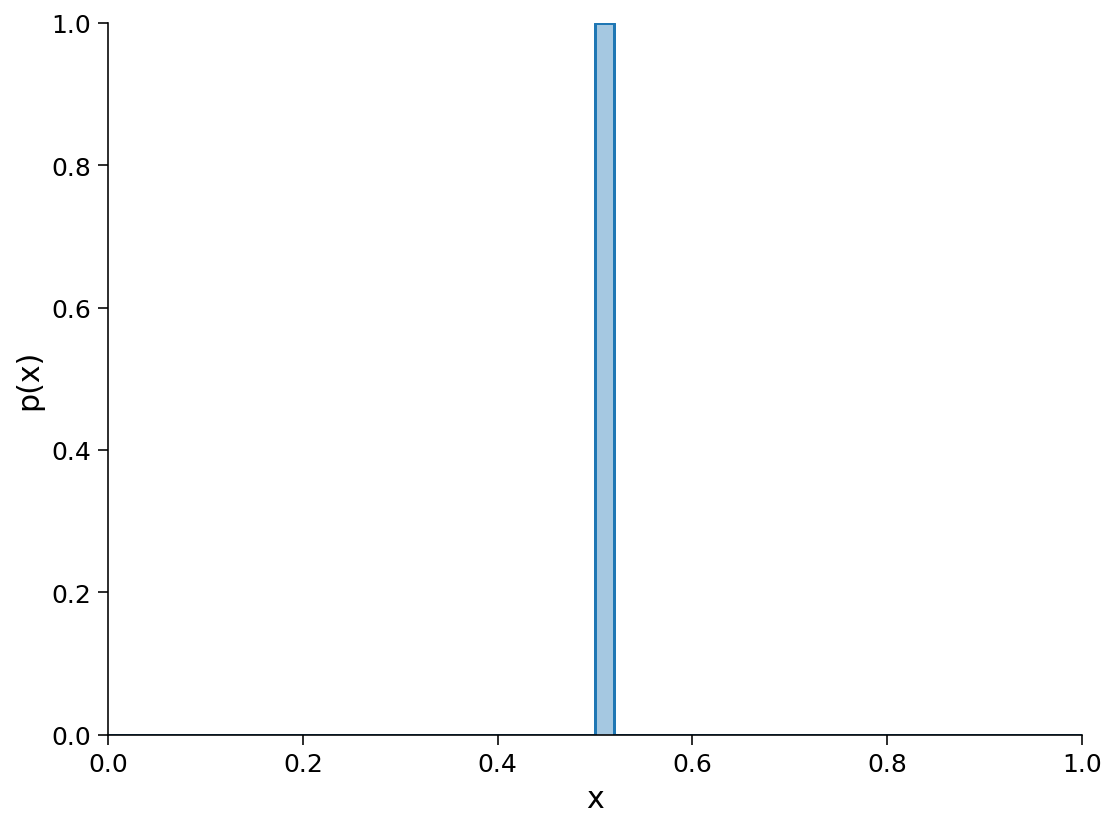

In [7]:
n_bins = 50  # number of points supporting the distribution
x_range = (0, 1)  # will be subdivided evenly into bins corresponding to points

bins = np.linspace(*x_range, n_bins + 1)  # bin edges

pmf = np.zeros(n_bins)
pmf[len(pmf) // 2] = 1.0  # middle point has all the mass

# Since we already have a PMF, rather than un-binned samples, `plt.hist` is not
# suitable. Instead, we directly plot the PMF as a step function to visualize
# the histogram:
pmf_ = np.insert(pmf, 0, pmf[0])  # this is necessary to align plot steps with bin edges
plt.plot(bins, pmf_, drawstyle="steps")
# `fill_between` provides area shading
plt.fill_between(bins, pmf_, step="pre", alpha=0.4)
plt.xlabel("x")
plt.ylabel("p(x)")
plt.xlim(x_range)
plt.ylim(0, 1);

If we were to draw a sample from this distribution, we know exactly what we would get every time. Distributions where all the mass is concentrated on a single event are known as *deterministic*.

How much entropy is contained in a deterministic distribution? We will compute this in the next exercise.

## Coding Exercise 1: Computing Entropy

Your first exercise is to implement a method that computes the entropy of a discrete probability distribution, given its mass function. Remember that we are interested in entropy in units of _bits_, so be sure to use the correct log function. 

Recall that $\log(0)$ is undefined. When evaluated at $0$, NumPy log functions (such as `np.log2`) return `np.nan` ("Not a Number"). By convention, these undefined terms— which correspond to points in the distribution with zero mass—are excluded from the sum that computes the entropy.

In [8]:
def entropy(pmf):
  """Given a discrete distribution, return the Shannon entropy in bits.

  This is a measure of information in the distribution. For a totally
  deterministic distribution, where samples are always found in the same bin,
  then samples from the distribution give no more information and the entropy
  is 0.

  For now this assumes `pmf` arrives as a well-formed distribution (that is,
  `np.sum(pmf)==1` and `not np.any(pmf < 0)`)

  Args:
    pmf (np.ndarray): The probability mass function for a discrete distribution
      represented as an array of probabilities.
  Returns:
    h (number): The entropy of the distribution in `pmf`.

  """
  ############################################################################
  # Exercise for students: compute the entropy of the provided PMF
  #   1. Exclude the points in the distribution with no mass (where `pmf==0`).
  #      Hint: this is equivalent to including only the points with `pmf>0`.
  #   2. Implement the equation for Shannon entropy (in bits).
  #  When ready to test, comment or remove the next line
#   raise NotImplementedError("Exercise: implement the equation for entropy")
  ############################################################################

  # reduce to non-zero entries to avoid an error from log2(0)
  pmf = pmf[pmf!=0]

  # implement the equation for Shannon entropy (in bits)
  h = -np.sum(pmf * -np.log2(pmf))

  # return the absolute value (avoids getting a -0 result)
  return np.abs(h)

# Call entropy function and print result
print(f"{entropy(pmf):.2f} bits")

0.00 bits


In [9]:
# to_remove solution
def entropy(pmf):
  """Given a discrete distribution, return the Shannon entropy in bits.

  This is a measure of information in the distribution. For a totally
  deterministic distribution, where samples are always found in the same bin,
  then samples from the distribution give no more information and the entropy
  is 0.

  For now this assumes `pmf` arrives as a well-formed distribution (that is,
  `np.sum(pmf)==1` and `not np.any(pmf < 0)`)

  Args:
    pmf (np.ndarray): The probability mass function for a discrete distribution
      represented as an array of probabilities.
  Returns:
    h (number): The entropy of the distribution in `pmf`.
  """
  # reduce to non-zero entries to avoid an error from log2(0)
  pmf = pmf[pmf > 0]

  # implement the equation for Shannon entropy (in bits)
  h = -np.sum(pmf * np.log2(pmf))

  # return the absolute value (avoids getting a -0 result)
  return np.abs(h)

# Call entropy function and print result
print(f"{entropy(pmf):.2f} bits")

0.00 bits


We expect zero surprise from a deterministic distribution. If we had done this calculation by hand, it would simply be $-1\log_2 1 = -0=0$.

Note that changing the location of the peak (i.e. the point and bin on which all the mass rests) doesn't alter the entropy. The entropy is about how predictable a sample is with respect to a distribution. A single peak is deterministic regardless of which point it sits on - the following plot shows a PMF that would also have zero entropy.

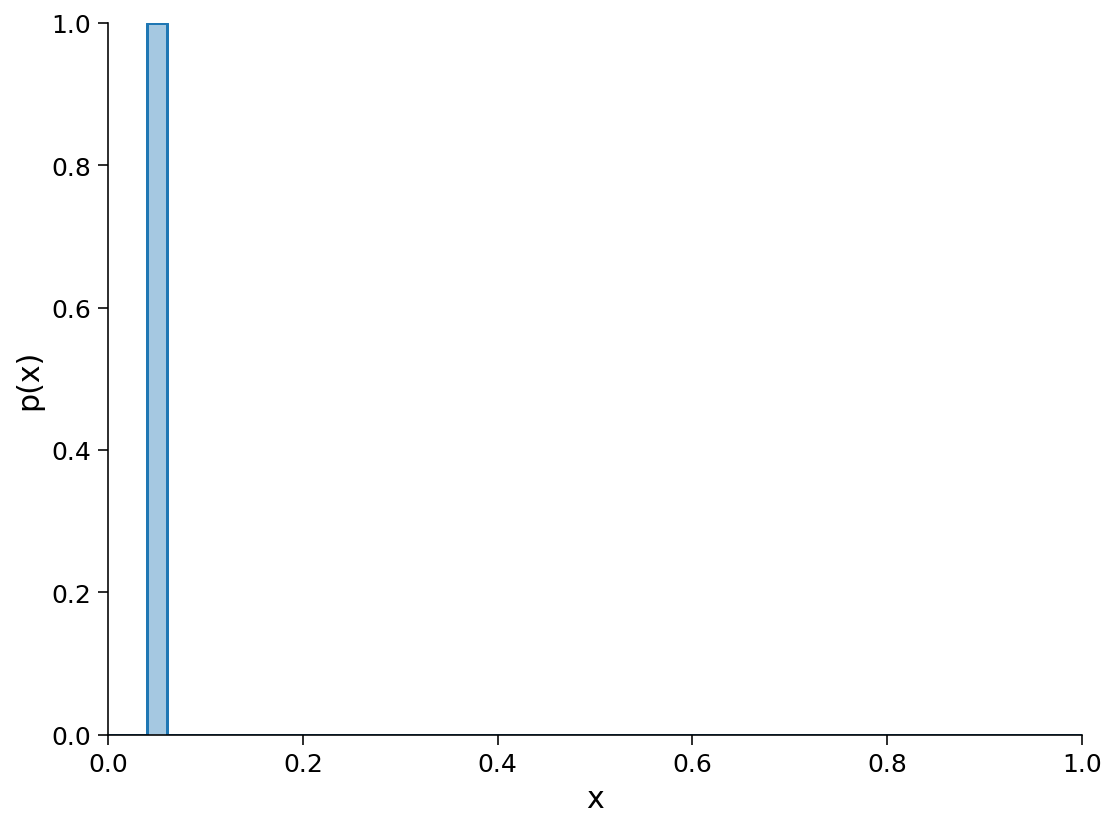

In [10]:
# @markdown Execute this cell to visualize another PMF with zero entropy
pmf = np.zeros(n_bins)
pmf[2] = 1.0  # arbitrary point has all the mass

pmf_ = np.insert(pmf, 0, pmf[0])
plt.plot(bins, pmf_, drawstyle="steps")
plt.fill_between(bins, pmf_, step="pre", alpha=0.4)
plt.xlabel("x")
plt.ylabel("p(x)")
plt.xlim(x_range)
plt.ylim(0, 1);

What about a distribution with mass split equally between two points?

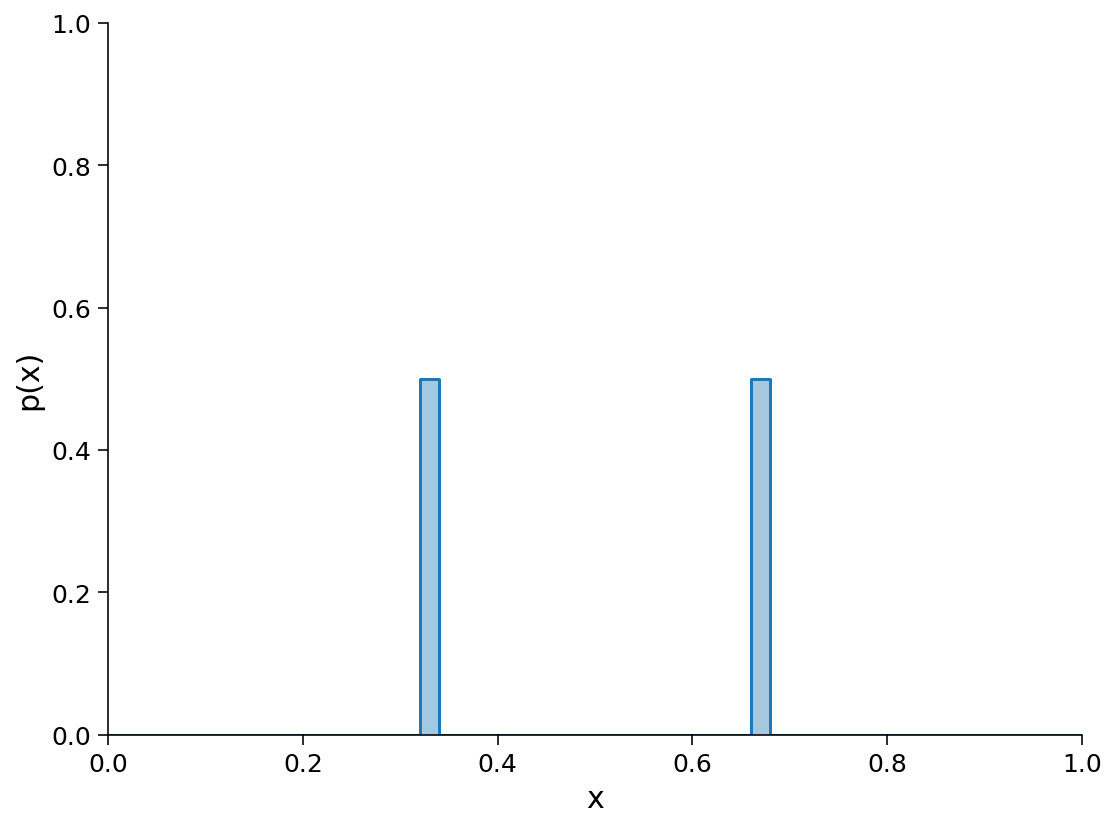

In [11]:
# @markdown Execute this cell to visualize a PMF with split mass

pmf = np.zeros(n_bins)
pmf[len(pmf) // 3] = 0.5
pmf[2 * len(pmf) // 3] = 0.5

pmf_ = np.insert(pmf, 0, pmf[0])
plt.plot(bins, pmf_, drawstyle="steps")
plt.fill_between(bins, pmf_, step="pre", alpha=0.4)
plt.xlabel("x")
plt.ylabel("p(x)")
plt.xlim(x_range)
plt.ylim(0, 1);

Here, the entropy calculation is: $-(0.5 \log_2 0.5 + 0.5\log_2 0.5)=1$

There is 1 bit of entropy. This means that before we take a random sample, there is 1 bit of uncertainty about which point in the distribution the sample will fall on: it will either be the first peak or the second one. 

Likewise, if we make one of the peaks taller (i.e. its point holds more of the probability mass) and the other one shorter, the entropy will decrease because of the increased certainty that the sample will fall on one point and not the other: : $-(0.2 \log_2 0.2 + 0.8\log_2 0.8)\approx 0.72$



Try changing the definition of the number and weighting of peaks, and see how the entropy varies.

If we split the probability mass among even more points, the entropy continues to increase. Let's derive the general form for $N$ points of equal mass, where $p_i=p=1/N$:

\begin{align}
-\sum_i p_i \log_b p_i &= -\sum_i^N \frac{1}{N} \log_b \frac{1}{N} \\
&= -\log_b \frac{1}{N} \\
&= \log_b N
\end{align}

If we have $N$ discrete points, the _uniform distribution_ (where all points have equal mass) is the distribution with the highest entropy: $\log_b N$. This upper bound on entropy is useful when considering binning strategies, as any estimate of entropy over $N$ discrete points (or bins) must be in the interval $[0, \log_b N]$.


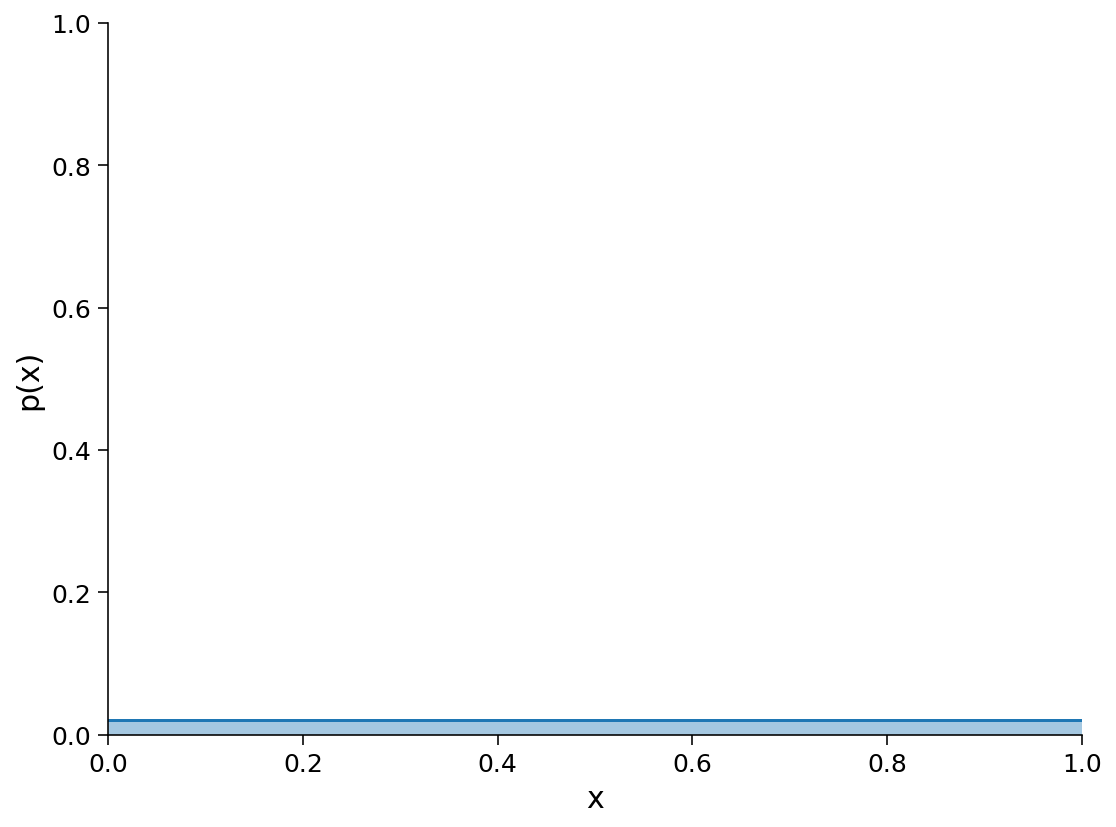

In [12]:
# @markdown Execute this cell to visualize a PMF of uniform distribution

pmf = np.ones(n_bins) / n_bins  # [1/N] * N

pmf_ = np.insert(pmf, 0, pmf[0])
plt.plot(bins, pmf_, drawstyle="steps")
plt.fill_between(bins, pmf_, step="pre", alpha=0.4)
plt.xlabel("x")
plt.ylabel("p(x)")
plt.xlim(x_range);
plt.ylim(0, 1);

Here, there are 50 points and the entropy of the uniform distribution is $\log_2 50\approx 5.64$. If we construct _any_ discrete distribution $X$ over 50 points (or bins) and calculate an entropy of $H_2(X)>\log_2 50$, something must be wrong with our implementation of the discrete entropy computation.

---
# Section 2: Information, neurons, and spikes

*Estimated timing to here from start of tutorial: 20 min*

In [13]:
# @title Video 2: Entropy of different distributions
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1df4y1976g", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="o6nyrx3KH20", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

Recall the discussion of spike times and inter-spike intervals (ISIs) from Tutorial 1. What does the information content (or distributional entropy) of these measures say about our theory of nervous systems? 

We'll consider three hypothetical neurons that all have the same mean ISI, but with different distributions:

1. Deterministic
2. Uniform
3. Exponential

Fixing the mean of the ISI distribution is equivalent to fixing its inverse: the neuron's mean firing rate. If a neuron has a fixed energy budget and each of its spikes has the same energy cost, then by fixing the mean firing rate, we are normalizing for energy expenditure. This provides a basis for comparing the entropy of different ISI distributions. In other words: if our neuron has a fixed budget, what ISI distribution should it express (all else being equal) to maximize the information content of its outputs?

Let's construct our three distributions and see how their entropies differ.

In [14]:
n_bins = 50
mean_isi = 0.025
isi_range = (0, 0.25)

bins = np.linspace(*isi_range, n_bins + 1)
mean_idx = np.searchsorted(bins, mean_isi)

# 1. all mass concentrated on the ISI mean
pmf_single = np.zeros(n_bins)
pmf_single[mean_idx] = 1.0

# 2. mass uniformly distributed about the ISI mean
pmf_uniform = np.zeros(n_bins)
pmf_uniform[0:2 * mean_idx] = 1 / (2 * mean_idx)

# 3. mass exponentially distributed about the ISI mean
pmf_exp = stats.expon.pdf(bins[1:], scale=mean_isi)
pmf_exp /= np.sum(pmf_exp)

In [15]:
# CORRECTION
n_bins = 50
mean_isi = .02
isi_range = (0, .25)

bins = np.linspace(*isi_range, n_bins + 1)
mean_idx = np.searchsorted(bins, mean_isi)

pmf_single = np.zeros(n_bins)
pmf_single[mean_idx] = 1

pmf_uniform = np.zeros(n_bins)
pmf_uniform[:] = mean_isi

pmf_exp = stats.expon.pdf(bins[1:], scale=mean_isi)
pmf_exp /= np.sum(pmf_exp)

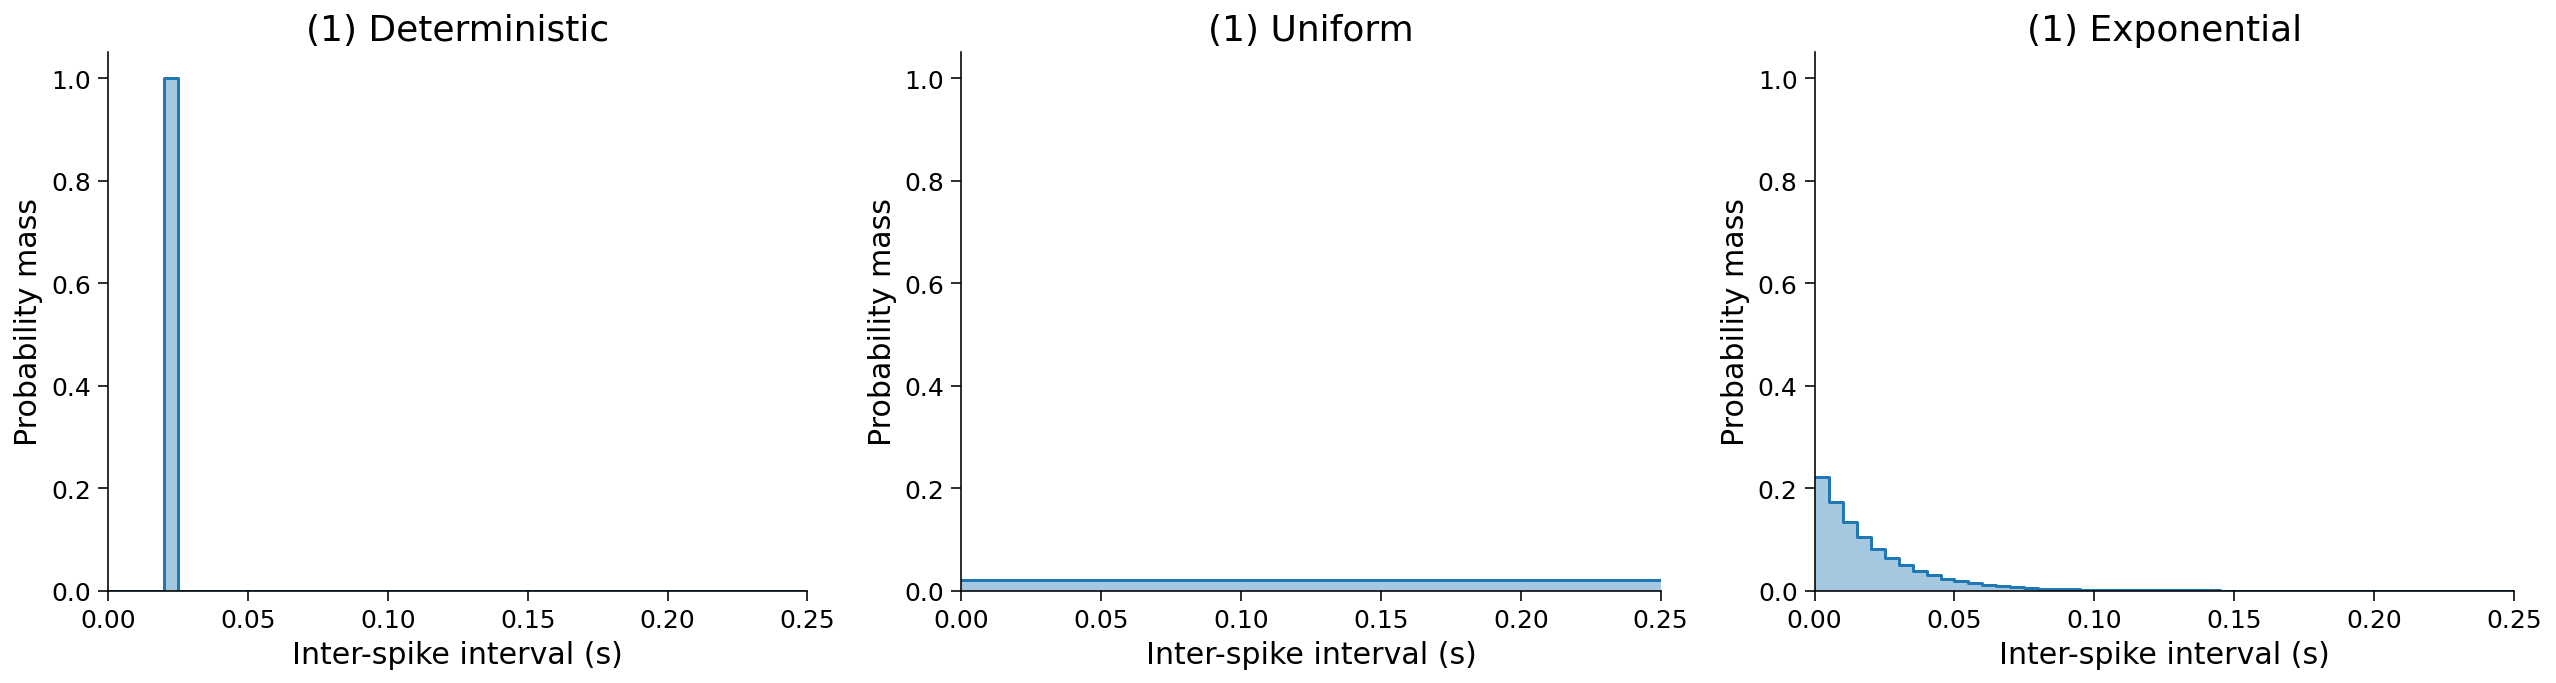

In [16]:
#@title
#@markdown Run this cell to plot the three PMFs
fig, axes = plt.subplots(ncols=3, figsize=(18, 5))

dists =  [# (subplot title, pmf, ylim)
          ("(1) Deterministic", pmf_single, (0, 1.05)),
          ("(1) Uniform", pmf_uniform, (0, 1.05)),
          ("(1) Exponential", pmf_exp, (0, 1.05))]

for ax, (label, pmf_, ylim) in zip(axes, dists):
  pmf_ = np.insert(pmf_, 0, pmf_[0])
  ax.plot(bins, pmf_, drawstyle="steps")
  ax.fill_between(bins, pmf_, step="pre", alpha=0.4)
  ax.set_title(label)
  ax.set_xlabel("Inter-spike interval (s)")
  ax.set_ylabel("Probability mass")
  ax.set_xlim(isi_range);
  ax.set_ylim(ylim);

In [17]:
print(
  f"Deterministic: {pmf_single.mean()}",
  f"Uniform: {pmf_uniform.mean()}",
  f"Exponential: {pmf_exp.mean()}",
  sep="\n",
)

Deterministic: 0.02
Uniform: 0.02
Exponential: 0.019999999999999997


In [18]:
print(
  f"Deterministic: {entropy(pmf_single):.2f} bits",
  f"Uniform: {entropy(pmf_uniform):.2f} bits",
  f"Exponential: {entropy(pmf_exp):.2f} bits",
  sep="\n",
)

Deterministic: 0.00 bits
Uniform: 5.64 bits
Exponential: 3.45 bits


In [75]:
np.random.poisson(.5, 10)

array([1, 1, 0, 0, 1, 0, 0, 0, 0, 1])

In [51]:
np.sum(np.random.poisson(.025, 100000))

2498

In [70]:
poisson_ = np.random.poisson(25, 1000)
# vals, bins = np.histogram(poisson_, 20)
# poisson_pmf = vals / vals.sum()

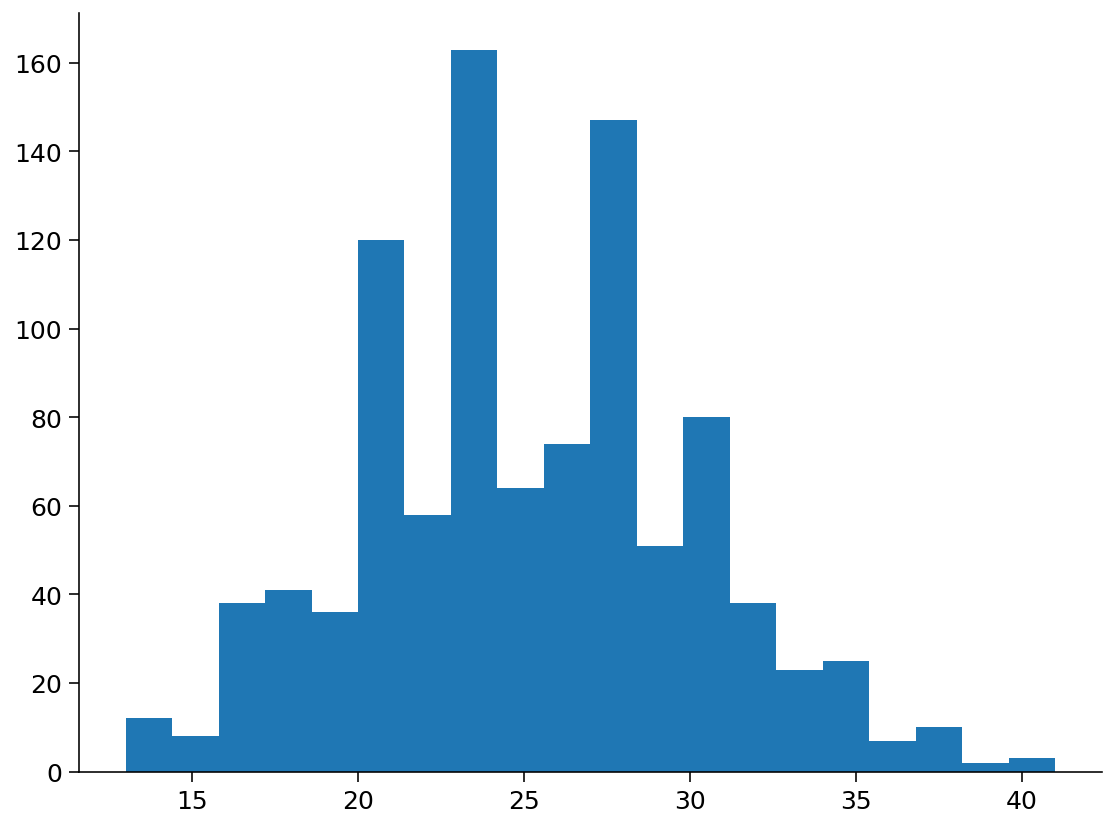

In [74]:
a = plt.hist(poisson_, 20)

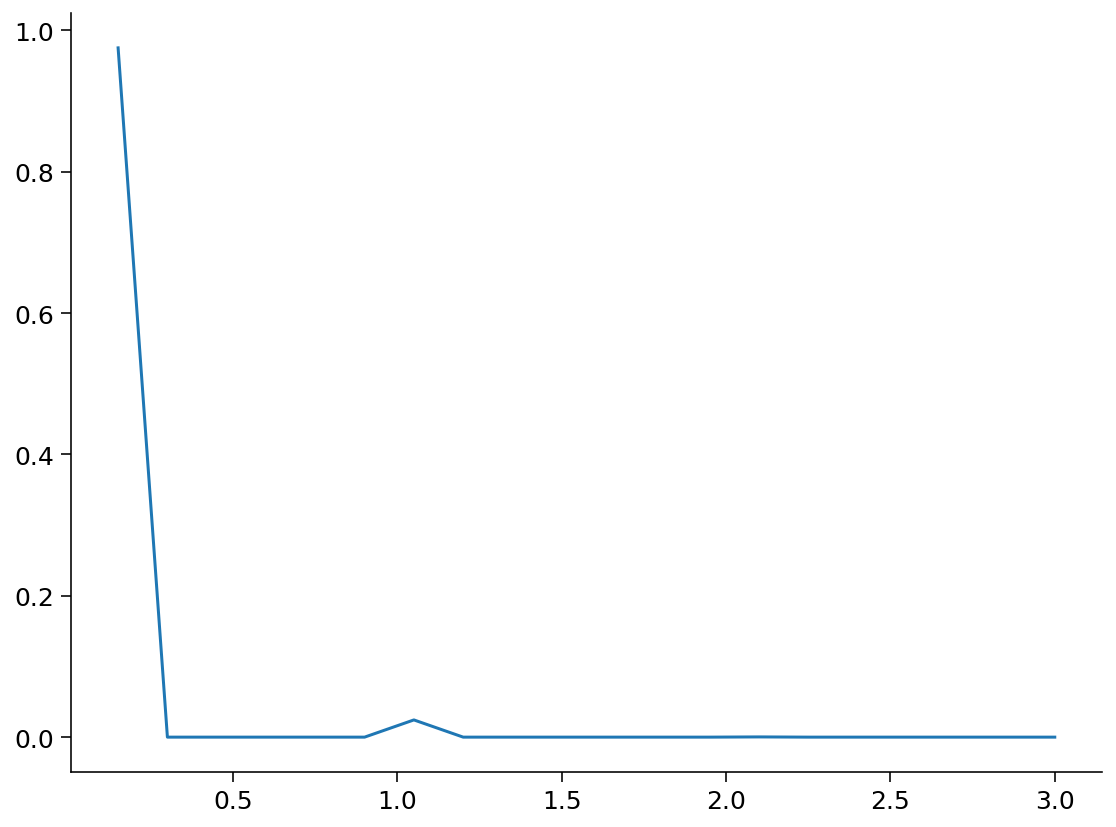

In [55]:
plt.plot(bins[1:], poisson_pmf)

In [424]:
entropy(poisson_pmf)

3.2503514953302

---
# Section 3: Calculate entropy of ISI distributions from data

*Estimated timing to here from start of tutorial: 25 min*

## Section 3.1: Computing probabilities from histogram

In [40]:
# @title Video 3: Probabilities from histogram
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1Jk4y1B7cz", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="e2U_-07O9jo", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

In the previous example we created the PMFs by hand to illustrate idealized scenarios. How would we compute them from data recorded from actual neurons?

One way is to convert the ISI histograms we've previously computed into discrete probability distributions using the following equation:

\begin{equation}
p_i = \frac{n_i}{\sum\nolimits_{i}n_i}
\end{equation}

where $p_i$ is the probability of an ISI falling within a particular interval $i$ and $n_i$ is the count of how many ISIs were observed in that interval.

### Coding Exercise 3.1: Probability Mass Function

Your second exercise is to implement a method that will produce a probability mass function from an array of ISI bin counts.

To verify your solution, we will compute the probability distribution of ISIs from real neural data taken from the Steinmetz dataset.

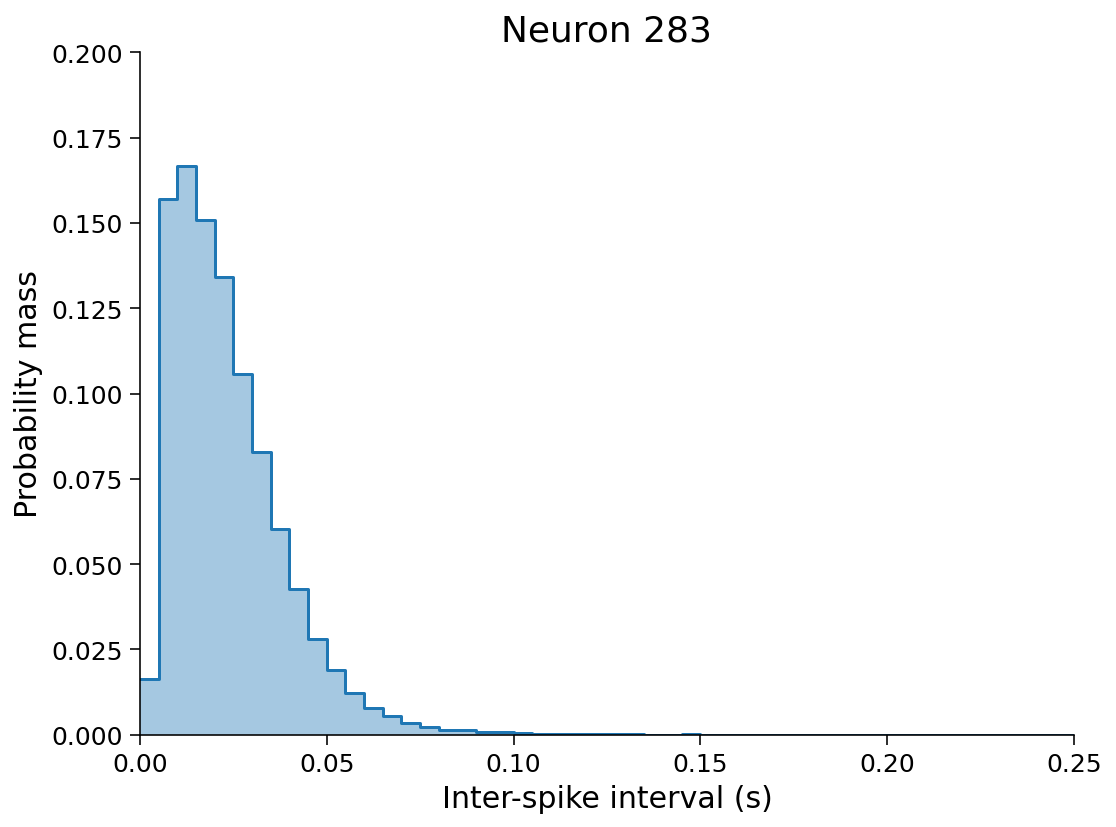

In [42]:
def pmf_from_counts(counts):
  """Given counts, normalize by the total to estimate probabilities."""
  ###########################################################################
  # Exercise: Compute the PMF. Remove the next line to test your function
#   raise NotImplementedError("Student exercise: compute the PMF from ISI counts")
  ###########################################################################

  pmf = counts / np.sum(counts)

  return pmf


# Get neuron index
neuron_idx = 283

# Get counts of ISIs from Steinmetz data
isi = np.diff(steinmetz_spikes[neuron_idx])
bins = np.linspace(*isi_range, n_bins + 1)
counts, _ = np.histogram(isi, bins)

# Compute pmf
pmf = pmf_from_counts(counts)

# Visualize
plot_pmf(pmf,isi_range)

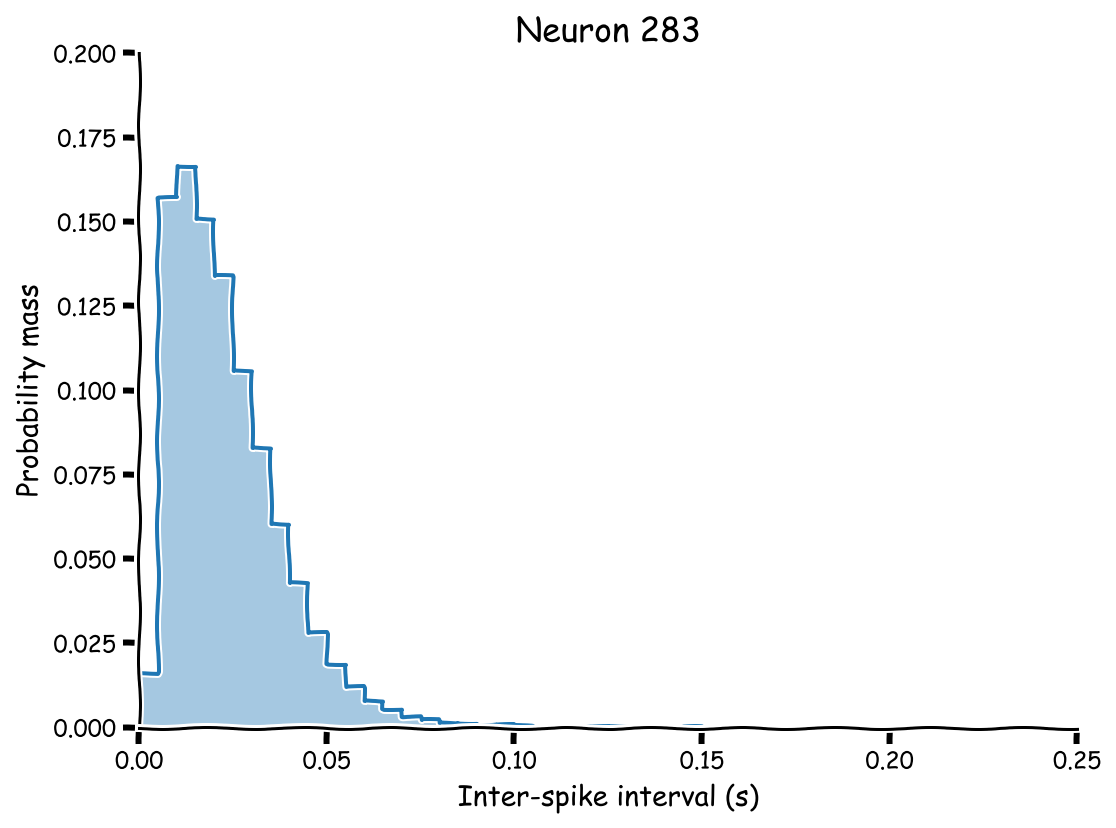

In [44]:
# to_remove solution
def pmf_from_counts(counts):
  """Given counts, normalize by the total to estimate probabilities."""
  pmf = counts / np.sum(counts)
  return pmf


# Get neuron index
neuron_idx = 283

# Get counts of ISIs from Steinmetz data
isi = np.diff(steinmetz_spikes[neuron_idx])
bins = np.linspace(*isi_range, n_bins + 1)
counts, _ = np.histogram(isi, bins)

# Compute pmf
pmf = pmf_from_counts(counts)

# Visualize
with plt.xkcd():
  plot_pmf(pmf,isi_range)

## Section 3.2: Calculating entropy from pmf

In [45]:
# @title Video 4: Calculating entropy from pmf
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1vA411e7Cd", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="Xjy-jj-6Oz0", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

Now that we have the probability distribution for the actual neuron spiking activity, we can calculate its entropy.

In [46]:
print(f"Entropy for Neuron {neuron_idx}: {entropy(pmf):.2f} bits")

Entropy for Neuron 283: 3.36 bits


### Interactive Demo 3.2: Entropy of neurons

We can combine the above distribution plot and entropy calculation with an interactive widget to explore how the different neurons in the dataset vary in spiking activity and relative information. Note that the mean firing rate across neurons is not fixed, so some neurons with a uniform ISI distribution may have higher entropy than neurons with a more exponential distribution.




In [47]:
#@title
#@markdown **Run the cell** to enable the sliders.

def _pmf_from_counts(counts):
  """Given counts, normalize by the total to estimate probabilities."""
  pmf = counts / np.sum(counts)
  return pmf

def _entropy(pmf):
  """Given a discrete distribution, return the Shannon entropy in bits."""
  # remove non-zero entries to avoid an error from log2(0)
  pmf = pmf[pmf > 0]
  h = -np.sum(pmf * np.log2(pmf))
  # absolute value applied to avoid getting a -0 result
  return np.abs(h)

@widgets.interact(neuron=widgets.IntSlider(0, min=0, max=(len(steinmetz_spikes)-1)))
def steinmetz_pmf(neuron):
  """ Given a neuron from the Steinmetz data, compute its PMF and entropy """
  isi = np.diff(steinmetz_spikes[neuron])
  bins = np.linspace(*isi_range, n_bins + 1)
  counts, _ = np.histogram(isi, bins)
  pmf = _pmf_from_counts(counts)

  plot_pmf(pmf,isi_range)
  plt.title(f"Neuron {neuron}: H = {_entropy(pmf):.2f} bits")

interactive(children=(IntSlider(value=0, description='neuron', max=733), Output()), _dom_classes=('widget-inte…

---
# Section 4: Reflecting on why models

*Estimated timing to here from start of tutorial: 35 min*

## Think! 3: Reflecting on how models

Please discuss the following questions for around 10 minutes with your group:

- Have you seen why models before?
- Have you ever done one?
- Why are why models useful?
- When are they possible? Does your field have why models?
- What do we learn from constructing them?

---
# Summary

*Estimated timing of tutorial: 45 minutes*

In [142]:
# @title Video 5: Summary of model types
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1F5411e7ww", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="X4K2RR5qBK8", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

Congratulations! You've finished your first NMA tutorial. In this 3 part tutorial series, we used different types of models to understand the spiking behavior of neurons recorded in the Steinmetz data set. 

 - We used "what" models to discover that the ISI distribution of real neurons is closest to an exponential distribution
 - We used "how" models to discover that balanced excitatory and inhibitory inputs, coupled with a leaky membrane, can give rise to neuronal spiking with exhibiting such an exponential ISI distribution
 - We used "why" models to discover that exponential ISI distributions contain the most information when the mean spiking is constrained



---
# Notation

\begin{align}
H(X) &\quad \text{entropy of random variable X}\\
b &\quad \text{base, e.g. b=2 or b=e}\\
x &\quad \text{event x}\\
p(x) &\quad \text{probability of observing event x}\\
\text{ISI} &\quad \text{interspike interval}\\
n_i &\quad \text{count of observed ISIs in interval i}\\
p_i  &\quad \text{probability of of an ISI falling within a particular interval i}
\end{align}

---
# Bonus

---
## Bonus Section 1: The foundations for Entropy

In his foundational [1948 paper](https://en.wikipedia.org/wiki/A_Mathematical_Theory_of_Communication) on information theory, Claude Shannon began with three criteria for a function $H$ defining the entropy of a discrete distribution of probability masses $p_i\in p(X)$ over the points $x_i\in X$:
1. $H$ should be continuous in the $p_i$. 
  - That is, $H$ should change smoothly in response to smooth changes to the mass $p_i$ on each point $x_i$.
2. If all the points have equal shares of the probability mass, $p_i=1/N$, $H$ should be a non-decreasing function of $N$. 
  - That is, if $X_N$ is the support with $N$ discrete points and $p(x\in X_N)$ assigns constant mass to each point, then $H(X_1) < H(X_2) < H(X_3) < \dots$
3. $H$ should be preserved by (invariant to) the equivalent (de)composition of distributions.
  - For example (from Shannon's paper) if we have a discrete distribution over three points with masses $(\frac{1}{2},\frac{1}{3},\frac{1}{6})$, then their entropy can be represented in terms of a direct choice between the three and calculated $H(\frac{1}{2},\frac{1}{3},\frac{1}{6})$. However, it could also be represented in terms of a series of two choices: 
    1. either we sample the point with mass $1/2$ or not (_not_ is the other $1/2$, whose subdivisions are not given in the first choice), 
    2. if (with probability $1/2$) we _don't_ sample the first point, we sample one of the two remaining points, masses $1/3$ and $1/6$.
    
    Thus in this case we require that $H(\frac{1}{2},\frac{1}{3},\frac{1}{6})=H(\frac{1}{2},\frac{1}{2}) + \frac{1}{2}H(\frac{1}{3}, \frac{1}{6})$

There is a unique function (up to a linear scaling factor) which satisfies these 3 requirements: 

\begin{equation}
H_b(X) = -\sum_{x\in X} p(x) \log_b p(x)
\end{equation}

Where the base of the logarithm $b>1$ controls the units of entropy. The two most common cases are $b=2$ for units of _bits_, and $b=e$ for _nats_.

We can view this function as the expectation of the self-information over a distribution:

\begin{align}
H_b(X) &= \mathbb{E}_{x\in X} \left[I_b(x)\right]\\
I_b(x) &= -\log_b p(x)
\end{align}

Self-information is just the negative logarithm of probability, and is a measure of how surprising an event sampled from the distribution would be. Events with $p(x)=1$ are certain to occur, and their self-information is zero (as is the entropy of the distribution they compose) meaning they are totally unsurprising. The smaller the probability of an event, the higher its self-information, and the more surprising the event would be to observe. 
